# 한개의 변수로 Linear regreesion

In [3]:
from __future__ import print_function
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn import metrics
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows=10
pd.options.display.float_format='{:.1f}'.format

In [5]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

In [6]:
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))
california_housing_dataframe["median_house_value"] /= 1000
california_housing_dataframe

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
4743,-118.1,33.9,28.0,1035.0,275.0,1545.0,269.0,3.0,123.4
10973,-120.9,38.1,9.0,3585.0,680.0,1800.0,598.0,3.6,133.1
16507,-122.6,38.2,40.0,1974.0,410.0,1039.0,398.0,3.8,151.6
16670,-122.8,38.5,9.0,3659.0,652.0,1889.0,632.0,4.3,250.8
10913,-120.8,37.5,45.0,350.0,62.0,187.0,63.0,2.6,275.0
...,...,...,...,...,...,...,...,...,...
4069,-118.0,33.7,14.0,6090.0,1338.0,1974.0,1248.0,2.8,180.3
4387,-118.0,33.8,25.0,1759.0,404.0,1404.0,385.0,3.6,195.8
7658,-118.4,33.9,39.0,1073.0,206.0,556.0,204.0,4.9,245.6
5525,-118.2,34.1,39.0,787.0,181.0,731.0,179.0,3.2,158.5


In [9]:
california_housing_dataframe.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207.3
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,116.0
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,15.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119.4
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180.4
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500.0


In [10]:
total_rooms = california_housing_dataframe[["total_rooms"]]
feature_columns = [tf.feature_column.numeric_column("total_rooms")]

In [12]:
targets = california_housing_dataframe["median_house_value"]
targets_columns = [tf.feature_column.numeric_column("median_house_value")]

In [42]:
my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.0000001)
my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(optimizer,5.0)

In [43]:
linear_regressor = tf.estimator.LinearRegressor(feature_columns=feature_columns,optimizer=optimizer)

In [44]:
def my_input_fn(features,targets,batch_size=1,shuffle=True,num_epoch=None):
    features = {key:np.array(value) for key,value in dict(features).items()}
    ds = Dataset.from_tensor_slices((features,targets))
    ds = ds.batch(batch_size).repeat(num_epoch)
    
    if shuffle == True:
        ds = ds.shuffle(buffer_size=10000)
    
    features,labels = ds.make_one_shot_iterator().get_next()
    return features,labels

# **Model Test1**

In [45]:
_ = linear_regressor.train(
    input_fn=lambda : my_input_fn(total_rooms,targets), steps=100
)

In [46]:
prediction_input_fn = lambda: my_input_fn(total_rooms,targets,num_epoch=1,shuffle=False)
predictions = linear_regressor.predict(input_fn=prediction_input_fn)
predictions = np.array([item['predictions'][0] for item in predictions])

mean_squared_error = metrics.mean_squared_error(predictions,targets)
root_mean_squared_error = math.sqrt(mean_squared_error)
print("Mean Squared Error : %0.3f" %mean_squared_error)
print("Root Mean Squared Error %0.3f" %root_mean_squared_error)

Mean Squared Error : 56367.025
Root Mean Squared Error 237.417


In [47]:
calibration_data = pd.DataFrame()
calibration_data['predictions'] = pd.Series(predictions)
calibration_data["targets"] = pd.Series(targets)
calibration_data.describe()

,predictions,targets
count,17000.0,17000.0
mean,0.1,207.3
std,0.1,116.0
min,0.0,15.0
25%,0.1,119.4
50%,0.1,180.4
75%,0.2,265.0
max,1.9,500.0


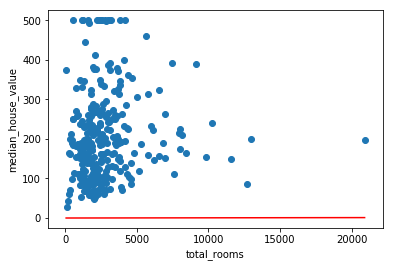

In [48]:
sample = california_housing_dataframe.sample(n=300)

x_0 = sample["total_rooms"].min()
x_1 = sample["total_rooms"].max()

weight = linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0]
bias = linear_regressor.get_variable_value('linear/linear_model/bias_weights')

y_0 = weight * x_0 + bias 
y_1 = weight * x_1 + bias

plt.plot([x_0, x_1], [y_0, y_1], c='r')

plt.ylabel("median_house_value")
plt.xlabel("total_rooms")

plt.scatter(sample["total_rooms"], sample["median_house_value"])

plt.show()

# Model Test2

In [68]:
def train_model(learning_rate, steps,batch_size,input_feature="total_rooms"):
    periods = 10
    steps_per_period = steps/periods
    
    total_rooms = input_feature
    total_rooms_data = california_housing_dataframe[[total_rooms]]
    targets = "median_house_value"
    targets = california_housing_dataframe[targets]
    
    #create Feature Columns
    feature_columns = [tf.feature_column.numeric_column(total_rooms)]
    
    #create input Func
    training_input_fn = lambda: my_input_fn(total_rooms_data,targets,batch_size=batch_size,shuffle=True,num_epoch=None)
    prediction_input_fn = lambda:my_input_fn(total_rooms_data,targets,num_epoch=1,shuffle=False)
    
    #create Linear regressor
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer,5.0)
    linear_regressor=tf.estimator.LinearRegressor(feature_columns=feature_columns,optimizer=my_optimizer)
    
    #train
    print("Training model...")
    root_mean_squared_errors = []
    for period in range (0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        #print("W:%0.2f b:%0.2f"%(linear_regressor.get_variable_value('linear/linear_model/total_rooms/weights')[0] ,linear_regressor.get_variable_value('linear/linear_model/bias_weights')))

        predictions = linear_regressor.predict(input_fn=prediction_input_fn)
        predictions = np.array([item['predictions'][0] for item in predictions])

        
        root_mean_squared_error = math.sqrt(
            metrics.mean_squared_error(predictions, targets))
        # Occasionally print the current loss.
        print("  period %02d : %0.2f" % (period, root_mean_squared_error))
        
    print("Model training finished.")


In [72]:
train_model(learning_rate=0.00001,steps=1000,batch_size=1)

Training model...
  period 00 : 225.63
  period 01 : 214.42
  period 02 : 204.04
  period 03 : 194.97
  period 04 : 187.23
  period 05 : 181.34
  period 06 : 176.33
  period 07 : 172.53
  period 08 : 170.23
  period 09 : 168.13
Model training finished.


In [73]:
train_model(learning_rate=0.00003,steps=1000,batch_size=5)

Training model...
  period 00 : 204.04
  period 01 : 180.40
  period 02 : 170.16
  period 03 : 166.31
  period 04 : 167.71
  period 05 : 171.57
  period 06 : 173.19
  period 07 : 174.38
  period 08 : 175.66
  period 09 : 177.03
Model training finished.


# Test model 3 (Population)

In [71]:
train_model(learning_rate=0.00002,steps=1000,batch_size=5,input_feature="population")

Training model...
  period 00 : 225.63
  period 01 : 214.62
  period 02 : 205.24
  period 03 : 196.75
  period 04 : 189.66
  period 05 : 184.68
  period 06 : 180.76
  period 07 : 178.42
  period 08 : 176.77
  period 09 : 176.10
Model training finished.
